# XGBoost with Logistic Regression
## Justin Heer, 301282991

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score,classification_report, recall_score, precision_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
%config Completer.use_jedi = False

In [2]:
df = pd.read_csv('database/processed-data.csv',index_col=0)

Create custom eval metric 

In [4]:
def custom_loss(y, t, threshold=0.5):
    t = t.get_label()
    y_bin = (y > threshold).astype(int) # works for both type(y) == <class 'numpy.ndarray'> and type(y) == <class 'pandas.core.series.Series'>
    r = recall_score(t,y_bin)
    p = precision_score(t,y_bin)
    
    s = r*0.6 + p*0.4
    
    return 'f1',s

#### Parameter tuning on multiple models, iterate through the hyperparameters using coordinate descent method

In [6]:
inx1 = df['stroke'] ==1
stroke_df = df.loc[inx1,:]
C = np.linspace(0.0001,10,1000)
scores = []
bNTrees = []
for i in range(0,50):
    if i%10==0:
        print(f"current iteration is {i}")
    
    no_stroke_df = df.loc[~inx1,:].sample(247)

    df_sample = pd.concat((stroke_df,no_stroke_df))
    y = df_sample['stroke']
    X = df_sample.drop('stroke', axis=1).values
    
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_val,y_val,test_size=0.2,random_state=1)
    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_val, y_val)
    dtest = xgb.DMatrix(X_test,y_test)
    
    score = []
    bNTree = []
    evallist = [(dtrain, 'train'),(dval, 'eval')]
    num_round = 200
    
    
    for c in C:
        param = {
            'booster':'gbtree',
            'lambda':0.4,
            'alpha':0,
            'eta':0.1,
            'max_depth':2,
            'min_child_weight':47.5,
            'gamma' : 0.4,
            'objective':'binary:hinge',
            'nthread':4,
            'verbosity':0,
            'disable_default_eval_metric': 1
        }
        
        bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 20,feval=custom_loss, maximize=True, verbose_eval=False)
        score.append(bst.best_score)
        bNTree.append(bst.best_ntree_limit)
    scores.append(score)
    bNTrees.append(bNTree)
scores = np.array(scores)
bNTrees = np.array(bNTrees)

current iteration is 0
current iteration is 10
Wall time: 1min


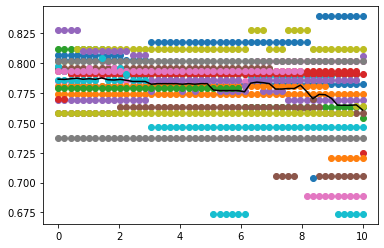

In [225]:
mean_score = scores.mean(axis=0)

for score in scores:
    plt.plot(C,score,'o')
plt.plot(C,mean_score,'-k')
plt.show()

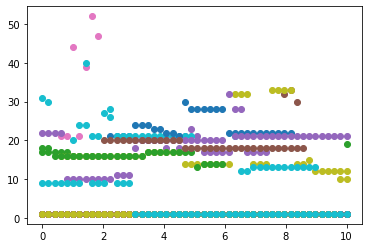

In [226]:
for counts in bNTrees :
    plt.plot(C,counts,'o')
# plt.plot(C,bNTrees.mean(axis=0),'-k')

#### Test the performance of the hyperparameters on the test data

In [7]:
inx1 = df['stroke'] ==1
stroke_df = df.loc[inx1,:]
scores = []
recs = [] 
precs = []
for i in range(0,50):
    if i%10==0:
        print(f"current iteration is {i}")
    no_stroke_df = df.loc[~inx1,:].sample(247)

    df_sample = pd.concat((stroke_df,no_stroke_df))
    y = df_sample['stroke']
    X = df_sample.drop('stroke', axis=1).values
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test,y_test)
    
    score = []
    num_round = 36
    
    param = {
            'booster':'gbtree',
            'lambda':0.4,
            'alpha':0,
            'eta':0.1,
            'max_depth':2,
            'min_child_weight':47.5,
            'gamma' : 0.4,
            'objective':'binary:hinge',
            'nthread':4,
            'verbosity':0,
            'disable_default_eval_metric': 1
        }
        
    bst = xgb.train(param, dtrain, num_round,feval=custom_loss, maximize=True, verbose_eval=False)
    y_pred = bst.predict(dtest)
    
    _,score = custom_loss(y_pred,dtest)
    scores.append(score)
    recs.append(recall_score(dtest.get_label(), y_pred))
    precs.append(precision_score(dtest.get_label(), y_pred))

scores = np.array(scores)
recs = np.array(recs)
precs = np.array(precs)

current iteration is 0
current iteration is 10
current iteration is 20
current iteration is 30
current iteration is 40
Wall time: 520 ms


In [15]:
print(f"scores = {scores.mean()}, recs = {recs.mean()}, precs = {precs.mean()}") 

scores = 0.8120829914203773, recs = 0.9353488372093024, precs = 0.62718422273699


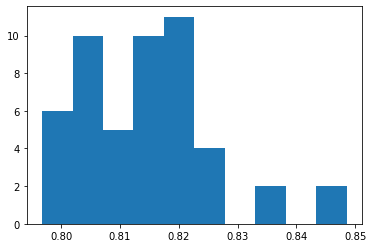

In [234]:
plt.hist(scores)
plt.show()